In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras

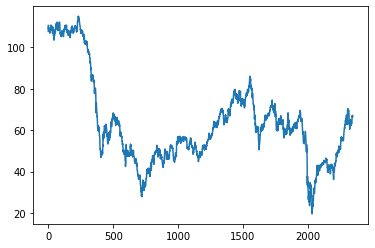

In [ ]:
dataset = pandas.read_csv('Brent.csv', usecols=[4],sep=';',decimal=',')
plt.plot(dataset)
plt.show()

In [ ]:
numpy.random.seed(1)

In [ ]:
dataset = dataset.values
dataset = dataset.astype('float32')
dataset

array([[107.75],
       [110.74],
       [108.82],
       ...,
       [ 66.4 ],
       [ 67.16],
       [ 66.49]], dtype=float32)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

1572 775


In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
look_back = 31*12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=20, verbose=2,shuffle=True)

60/60 - 2s - loss: 0.0079


In [ ]:
import numpy as np
import tqdm

for i in tqdm.trange(testY.shape[0]):
  trainY=np.concatenate((trainY,model.predict(trainY[-look_back:].reshape(1,1,look_back))[0]),axis=None)

100%|██████████| 402/402 [00:17<00:00, 23.43it/s]


In [ ]:
# make predictions
# invert predictions
trainY_train = scaler.inverse_transform(trainY[:trainX.shape[0]].reshape(1,-1))
testPredict = scaler.inverse_transform(trainY[trainX.shape[0]:].reshape(1,-1))
testYnew = scaler.inverse_transform(testY.reshape(1,-1))
# calculate root mean squared error
testScore1=[]
for i in range (1,testYnew.shape[1]):
  testScore1.append(np.sqrt(mean_squared_error(testYnew[0][:i],testPredict[0][:i])))
  #print(testYnew[:i],testPredict[:i],testScore1[-1])
testScore = mean_squared_error(testYnew, testPredict)
print('Test Score: %.2f MSE' % (testScore))

Test Score: 1010.45 MSE


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


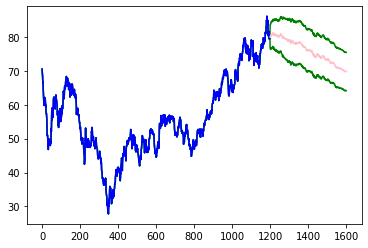

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[:trainX.shape[0], :] = scaler.inverse_transform(trainY[:trainX.shape[0]].reshape(1,-1)).T
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[trainX.shape[0]:trainY.shape[0],:] = testPredict.T
# plot baseline and predictions
m=list(trainY_train[0][:trainX.shape[0]])
k=list(trainY_train[0][:trainX.shape[0]])
for i in range (len(testScore1)):
 m.append(np.sqrt(testScore1[i])+testPredictPlot[i+trainX.shape[0],:])
 k.append(testPredictPlot[i+trainX.shape[0],:]-np.sqrt(testScore1[i]))
plt.plot(m, color='green')
plt.plot(k, color='green')
plt.plot(trainPredictPlot, color='blue')
plt.plot(testPredictPlot,color='pink')
plt.show()
